In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spa
from matplotlib.patches import Ellipse
import pandas
import matplotlib as mpl
import math

In [2]:
np.random.seed(421)
# sample size
N = 300
# cluster count
K = 5

In [3]:
# generate random samples
X1 = np.random.multivariate_normal(np.array([+2.5, +2.5]), np.array([[0.8, -0.6], [-0.6, 0.8]]), N // 6)
X2 = np.random.multivariate_normal(np.array([-2.5, +2.5]), np.array([[0.8, 0.6], [0.6, 0.8]]), N // 6)
X3 = np.random.multivariate_normal(np.array([-2.5, -2.5]), np.array([[0.8, -0.6], [-0.6, 0.8]]), N // 6)
X4 = np.random.multivariate_normal(np.array([+2.5, -2.5]), np.array([[0.8, 0.6], [0.6, 0.8]]), N // 6)
X5 = np.random.multivariate_normal(np.array([+0.0, +0.0]), np.array([[1.6, 0.0], [0.0, 1.6]]), N // 3)
X = np.vstack((X1, X2, X3, X4, X5))

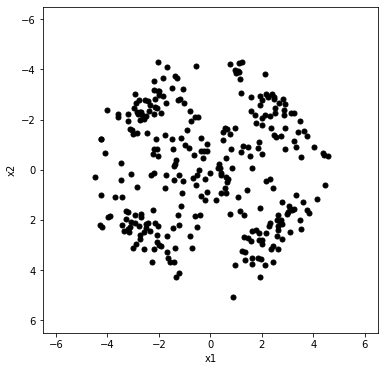

In [4]:
plt.figure(figsize = (6, 6))
plt.xlim(right = 6.5)
plt.xlim(left = -6.5)
plt.ylim(bottom = 6.5)
plt.ylim(top = -6.5)
plt.plot(X[:,0], X[:,1], ".", markersize = 10, color = "black")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [5]:
#k-means clustering function from the lab
def update_centroids(memberships, X):
    if memberships is None:
        # initialize centroids
        centroids = X[np.random.choice(range(N), K),:]
    else:
        # update centroids
        centroids = np.vstack([np.mean(X[memberships == k,], axis = 0) for k in range(K)])
    return(centroids)

def update_memberships(centroids, X):
    # calculate distances between centroids and data points
    D = spa.distance_matrix(centroids, X)
    # find the nearest centroid for each data point
    memberships = np.argmin(D, axis = 0)
    return(memberships)

In [6]:
#current state function
def plot_current_state(memberships, X):
    cluster_colors = np.array(["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"])
    cluster_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
                               "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"])
    if memberships is None:
        plt.plot(X[:,0], X[:,1], ".", markersize = 10, color = "black")
    else:
        for c in range(K):
            plt.plot(X[memberships == c, 0], X[memberships == c, 1], ".", markersize = 10, 
                     color = cluster_colors[c])
#     for c in range(K):
#         plt.plot(centroids[c, 0], centroids[c, 1], "s", markersize = 12, 
#                  markerfacecolor = cluster_colors[c], markeredgecolor = "black")
    plt.xlabel("x1")
    plt.ylabel("x2")

In [7]:
centroids = None
memberships = None
iteration = 1
#running the k-means clustering for two iterations
while iteration<3:

    old_centroids = centroids
    centroids = update_centroids(memberships, X)

    old_memberships = memberships
    memberships = update_memberships(centroids, X)

    iteration = iteration + 1

In [8]:
h = np.zeros((N,K))
varPi = np.zeros((K,1))
varMean = np.zeros((K,2))
varCov = np.zeros((K*2,2))
piInit = np.zeros((K,1))
meanInit = np.zeros((K,2))
covInit = np.zeros((K*2,2))
m = np.zeros((K,1))
memberships1 = np.zeros((N,1))

#initialization for the EM algorithm, using the values from the k-means algorithm
for i in range(K):
    piInit[i] = sum(memberships == i)/N
    meanInit[i] = np.mean(X[memberships == i], axis = 0)
    covInit[2*i:2*i+2] = np.cov(X[memberships == i].T)
    
for i in range(K):
    for t in range(N):
        N1 = piInit[i]*1/(2*np.pi*np.linalg.det(covInit[2*i:2*i+2])**0.5)*np.exp(-0.5*(X[t]-meanInit[i]).T@np.linalg.inv(covInit[2*i:2*i+2])@(X[t]-meanInit[i]))
        Nk = np.sum([piInit[c]*1/(2*np.pi*np.linalg.det(covInit[2*c:2*c+2])**0.5)*np.exp(-0.5*(X[t]-meanInit[c]).T@np.linalg.inv(covInit[2*c:2*c+2])@(X[t]-meanInit[c])) for c in range(K)])
        h[t,i] = np.sum(N1/Nk)

memberships1 = np.argmax(h, axis = 1)
iteration = 1

#EM maximization loop that runs for 100 iterations
#the loop is not optimized so it takes a while to finish (approx 30 secs on a decent pc)
#please wait until the evaluation is over.
while iteration <100:
    
    oldMemberships1 = memberships1
    
    #M-step
    for i in range(K):
        m[i] = np.sum(h[:,i])
        varPi[i] = np.sum(h[:,i])/N
        varMean[i] = (1/m[i])*np.sum([(h[c,i]*X[c])for c in range(N)], axis = 0)
    for i in range(K):
        varCov[2*i:2*i+2] = (1/m[i])*np.sum([(h[c,i]*np.vstack((X[c]-varMean[i]))*(X[c]-varMean[i])) for c in range(N)], axis = 0)
    
    #E-step
    for i in range(K):
        for t in range(N):
            N1 = varPi[i]*1/(2*np.pi*np.linalg.det(varCov[2*i:2*i+2])**0.5)*np.exp(-0.5*(X[t]-varMean[i]).T@np.linalg.inv(varCov[2*i:2*i+2])@(X[t]-varMean[i]))
            Nk = np.sum([varPi[c]*1/(2*np.pi*np.linalg.det(varCov[2*c:2*c+2])**0.5)*np.exp(-0.5*(X[t]-varMean[c]).T@np.linalg.inv(varCov[2*c:2*c+2])@(X[t]-varMean[c])) for c in range(K)])
            h[t,i] = np.sum(N1/Nk)
            
    memberships1 = np.argmax(h, axis = 1)
    iteration = iteration + 1

In [9]:
print(pandas.DataFrame(varMean, np.arange(1,6), [1,2]))

          1         2
1 -2.616102  2.472964
2  2.448420  2.522215
3  2.459820 -2.378363
4 -0.275324 -0.145550
5 -2.436434 -2.578053


In [10]:
#combining means and covariances of the original data
#with the means and covariances from the algorithm
covOrig = np.zeros((K*2,2))
meanOrig = np.zeros((K,2))
meanOrig[0] = np.mean(X1, axis = 0)
meanOrig[1] = np.mean(X2, axis = 0)
meanOrig[2] = np.mean(X3, axis = 0)
meanOrig[3] = np.mean(X4, axis = 0)
meanOrig[4] = np.mean(X5, axis = 0)
covOrig[2*0:2*0+2] = np.cov(X1.T)
covOrig[2*1:2*1+2] = np.cov(X2.T)
covOrig[2*2:2*2+2] = np.cov(X3.T)
covOrig[2*3:2*3+2] = np.cov(X4.T)
covOrig[2*4:2*4+2] = np.cov(X5.T)
meanArr = np.concatenate((meanOrig, varMean), axis = 0)
covArr = np.concatenate((covOrig, varCov), axis = 0)

In [11]:
#function defined for drawing ellipses by using mean and covariance data
def drawEllipses(meanMat, covMat, K, s):
    ells = []
    r2d = 180/math.pi
    for i in range(K*2):
        mean = meanMat[i]
        cov = covMat[2*i:2*i+2]
        vals, vects = np.linalg.eig(cov)
        maxcol = list(vals).index(max(vals))
        eigenvect = vects[:,maxcol]
        if vals[0]>vals[1]:
            height = 2*math.sqrt(s*vals[1])
            width = 2*math.sqrt(s*vals[0])
        else:
            height = 2*math.sqrt(s*vals[0])
            width = 2*math.sqrt(s*vals[1])
        angle = np.arctan2(eigenvect[1],eigenvect[0])
        angle = angle*r2d
        if i > 4:
            ls = '--'
        else:
            ls = '-'
        ell = mpl.patches.Ellipse(mean, width, height, angle, fill = False, ls = ls)
        ells.append(ell)
    ells = np.asarray(ells)
    return(ells)

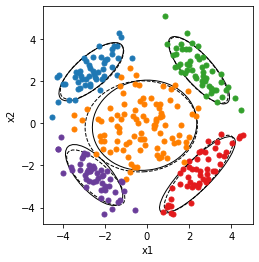

In [12]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
plot_current_state(memberships1, X)
s = 3 #confidence constant
ells = drawEllipses(meanArr, covArr, K, s)
for i in range(2*K):
    ax.add_artist(ells[i])
plt.show()
